# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Granger-Causality" data-toc-modified-id="Granger-Causality-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Granger Causality</a></div><div class="lev1 toc-item"><a href="#Assumptions-and-drawbacks" data-toc-modified-id="Assumptions-and-drawbacks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Assumptions and drawbacks</a></div><div class="lev1 toc-item"><a href="#Python-implementation" data-toc-modified-id="Python-implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Python implementation</a></div><div class="lev1 toc-item"><a href="#Example" data-toc-modified-id="Example-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Example</a></div><div class="lev2 toc-item"><a href="#Data" data-toc-modified-id="Data-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data</a></div><div class="lev2 toc-item"><a href="#Triple-wise-Granger-Analysis" data-toc-modified-id="Triple-wise-Granger-Analysis-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Triple-wise Granger Analysis</a></div><div class="lev2 toc-item"><a href="#Pairwise-Granger" data-toc-modified-id="Pairwise-Granger-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Pairwise Granger</a></div><div class="lev3 toc-item"><a href="#X-vs-Z" data-toc-modified-id="X-vs-Z-431"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>X vs Z</a></div><div class="lev3 toc-item"><a href="#Y-vs-Z" data-toc-modified-id="Y-vs-Z-432"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Y vs Z</a></div><div class="lev1 toc-item"><a href="#Comparison-with-statsmodels" data-toc-modified-id="Comparison-with-statsmodels-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comparison with statsmodels</a></div><div class="lev3 toc-item"><a href="#Triple-wise-Granger-analysis" data-toc-modified-id="Triple-wise-Granger-analysis-501"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Triple-wise Granger analysis</a></div><div class="lev3 toc-item"><a href="#Pairwise-Granger-analysis" data-toc-modified-id="Pairwise-Granger-analysis-502"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Pairwise Granger analysis</a></div>

@author: Damien Delforge <br>
@email: damien.delforge[at]uclouvain.be <br>
@date : March, 2019<br>

# Granger Causality

This notebook presents a quick introduction to Granger causality, how to compute it using Python scientific libraries _numpy_ and _scipy_ and how to visualize the results on a contingency table. The python library `statsmodels` already provide python implementation of Granger Causality with additional features. This notebook is rather intended for learning what lies beyond Granger causality and check the code machinery. The code and theory is inspired by `statsmodels` implementation which is itself based on [Lütkepohl (2005): _New Introduction to Multiple Time Series Analysis_](https://www.springer.com/us/book/9783540401728).

The present materials is distributed without any guarantees and validity of the outputs is left to the user's responsibility. 

**Definition**

Granger Causality refers to a test to address causality in the field of linear time series analysis. It is based on the principle that if the past of a variable $X$ causes a variable $Y$ at present, then information about $X$'s past should reduce significantly the forecast error of $Y$. This is generalized using Vector Auto Regression (VAR) models. For a $n \times m$ multivariate time series $\mathbf{Y}_t$ of $n$ observations and $m$ variables, a VAR model expresses the linear relationship between $\mathbf{Y}_t$ and its lagged values:

_Generalized VAR model_
$$
\mathbf{Y}_t = \mathbf{B}_1\mathbf{Y}_{t-1} + \ldots + \mathbf{B}_p\mathbf{Y}_{t-p} + c + \varepsilon_t
$$

where $\mathbf{B_i}$ are $m \times m$ coefficient matrices, $c$ is a constant vector, $\varepsilon_t$ the error component, and $p$ is the order (maximum lag) of the model. Let us notice that instantaneous relationship are not captured in a VAR model and all variables are the result of linear combinations of their own past values.Estimates $\hat{\mathbf{Y}}_t$ are obtained using least square optimization. 

**Testing for Granger causality**

For a univariate time series $y_t$, a VAR model is based on a successively delayed multivariate time series of an exhaustive set of predictors $\mathbf{\Omega}_t$ which usually includes $y_t$ as well to account for auto-correlation. To assess if univariate time series $x_t \in \mathbf{\Omega}_t$ Granger-causes $y_t$, we follow two-steps procedure involving VAR models fitting and F-test on the variance of residuals:

**1**) Two VAR models are fitted with to obtain $\hat{y}_t \bigm|  \mathbf{\Omega}_t$ and $\hat{y}_t \bigm|  \mathbf{\Omega}_t \setminus x_t$ and their respective forecast errors: $r_u = y_t - \hat{y}_t \bigm|  \mathbf{X}_t $ and
$r_c =  y_t - \hat{y}_t \bigm|  \mathbf{X}_t \setminus x_t
$, where $u$ and $c$ subscripts refer to _unconstrained_ and _constrained_ model.

**2**) The variance of residuals $\sigma_u^2 = Var(r_u)$ and $\sigma_c^2 = Var(r_c)$ are compared to check if $\sigma_u < \sigma_c$ is significant. This is done using a F-test where the f-value is given by:

_F-statistic for the Granger F-test_
$$
f = \frac{n-k}{p} \frac{\sigma_c^2 - \sigma_u^2}{\sigma_u^2}
$$

where $k$ is the number of regressors given by $k=p*m+1$. The $+1$ term refers to the additional constant $c$ in the model. The above formula is from the Python [`statsmodels` library source code](https://www.statsmodels.org/dev/_modules/statsmodels/tsa/vector_ar/var_model.html#VARResults.test_causality). A corresponding p-value is calculated using $1- F_F(f, d_1, d_2)$ where $F_F$ is a [a cumulative distribution function of a F continuous random variable](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html#scipy.stats.f), and where $d_1 = p$ and $d_2=m(n - k)$ are degrees of freedom. With respect to a confidence level $\alpha$, Granger causality is concluded if the p-value is lower than $\alpha$. 

Note that $n$ refers to the number of observation for which delayed data are available. Hence, if $N$ is the number of total observation, $n$ is given by $N-p$.

# Assumptions and drawbacks

Testing for Granger causality assumes that:

* The linear assumption is valid;
* All potential driving variables are used;
* All variables are stationary (constant mean and variance);
* The residuals are unbiaised ( ~ zero mean) and have no autocorrelation.

If variables are non stationary, one may use differencing to achieve it. Since it is not always easy to eyeball stationarity, common stationarity tests are the Augmented Dickey Fuller (ADF) test or the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests.
Common tests for testing for auto-correlation are the Ljung-Box test or the Box-Pierce test. One may also plot the auto-correlation function of residuals.

If two many variables are considered in the Granger causality analysis, the model might be irrelevant suffering from the Curse of Dimensionality. For this reason, Granger causality is often used for pairwise causal analysis, i.e. by comparing the performance of a univariate AR model to a bi-variate VAR model. 

If some explaining drivers are missing, causal link may be spurious. A common case is the following, if two variables $X$ and $Y$ are related to a third unknown variable $Z$ but not together, then a spurious link may result from the Granger Analysis as $Z$ is not included in the predictors.

# Python implementation

We implement 2 functions: `get_var_resid(df, maxlag)` and `test_granger(df, maxlag, alpha)`. The function `test_granger` performs granger causality analysis for a variables in the dataframe `df` with a parameter `maxlag` corresponding to the order of the VAR model and `alpha` corresponding to the p-value threshold to conclude for the Granger-causality. The function `get_var_resid` fit a VAR model for a `df` and returns the residuals.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def get_VAR_resid(df, maxlag):
    """Return residuals of a Vector Auto Regression Model
    
    The model is fitted using numpy.linalg.lstsq
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame of size (n, m) containing m time series of n observation.
        The `df` DataFrame is predicted variable of the VAR model. 
    maxlag : int
        Maximum delay for the VAR model.
        
    Returns
    -------
    residuals : pandas.DataFrame
        DataFrame of size (n, m) containing m time series of n observation.
        The `residuals` DataFrame are the residuals of the VAR model.
    """
    variables = df
    
    # build lagged regressors for variables
    predictors = pd.DataFrame()
    for i in range(1, maxlag+1):
        lagged = variables.shift(i)
        lagged.columns = ['L{}.{}'.format(i, col) for col in variables.columns]
        predictors = pd.concat([predictors,lagged], axis=1)
        
    # add constant to the model    
    predictors['cst'] = 1
    
    Y = variables.iloc[maxlag:].values
    X = predictors.iloc[maxlag:].values
    
    # Perform the least square optimization
    b_hat, _, _, _ =  np.linalg.lstsq(X,Y, rcond=None)
    # Perform prediction using fitted parameters b_hat
    Y_pred = np.dot(X, b_hat)
    
    #Output post-processing
    residuals = pd.DataFrame(Y-Y_pred, index=variables.index[maxlag:], columns=variables.columns)
    return  residuals

def test_granger(df, maxlag, alpha=0.05):
    """Test for Granger causality on a Time Series DataFrame
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame of size (n, m) containing m time series of n observation.
        The `df` DataFrame is predicted variable of the VAR model. 
    maxlag : int
        Maximum delay for the VAR model.
    alpha : int
        Level of significance [0,1].
        
    Returns
    -------
    granger : pandas.DataFrame
        DataFrame of size (m, m) containing boolean result of the
        Granger causality test. Rows are responses variables and
        columns are potential driving variables.
    fvalues : pandas.DataFrame
        DataFrame of size (m, m) containing F values of the
        Granger causality test. Rows are responses variables and
        columns are potential driving variables.
    pvalues : pandas.DataFrame
        DataFrame of size (m, m) containing p-values of the
        Granger causality test. Rows are responses variables and
        columns are potential driving variables.
    """
    
    tsnames = list(df.columns)
    
    # output initialization
    fvalues = pd.DataFrame(index=tsnames, columns=tsnames)
    pvalues = pd.DataFrame(index=tsnames, columns=tsnames)
    granger = pd.DataFrame(index=tsnames, columns=tsnames)
    
    for rv in [fvalues, pvalues, granger]:
        rv.index.name = 'response'
        rv.columns.name = 'driver'
    
    # Get residuals for unrestricted model
    r = get_VAR_resid(df, maxlag)
    v_all = np.var(r)

    p = maxlag # model order
    n = len(r) # number of observations
    m = len(df.columns) # number of variables
    k = m * p + 1 # number of regressors
    
    # Iterative F-test on restricted residuals
    for i, ts in enumerate(tsnames):
        
        col_restricted = [j for j in tsnames if j != tsnames[i]]
        df_restricted =  df[col_restricted]
        
        r_restricted = get_VAR_resid(df_restricted, maxlag)
        
        for j, rx in enumerate(r_restricted.columns):
            
            v = v_all[rx]
            vx = np.var(r_restricted[rx])
            
            # F test on both residuals variances
            f_value = (n-k)/p * (vx - v)/v
            p_value = 1 - stats.f.cdf(f_value, p, m*(n - k))
            fvalues.loc[rx, ts] = f_value
            pvalues.loc[rx, ts] = p_value
            granger.loc[rx, ts] = p_value < alpha
            
            
    return granger, fvalues, pvalues

# Example

## Data

We use synthetic data to generate a simple causal chain:
$$
X_t \rightarrow Y_t \rightarrow Z_t 
$$

The model is the following:
$$
\begin{eqnarray}
X_t = N(0,1) \\
Y_t = 0.2Y_{t-1} + 0.2X_{t-1} + 0.2N(0,1) \\
Z_t = 0.2Z_{t-1} + 0.2Y_{t-1} + 0.2N(0,1)
\end{eqnarray}
$$

The synthetic dataset is stored in a `pandas.DataFrame` object.

In [3]:
np.random.seed(0) # <-- remove it, this is a random seed for reproductible results, and interpretation
n = 500

xt = np.random.randn(n)
yt = np.zeros(len(xt))
zt = np.zeros(len(xt))

eps1 = np.random.randn(len(xt))
eps2 = np.random.randn(len(xt))

for i in range(3, len(yt) - 3):
    yt[i] = 0.2 * yt[i - 1] + 0.2 * xt[i - 1] + 0.2*eps1[i]
    zt[i] = 0.2 * zt[i - 1] + 0.2 * yt[i - 1] + 0.2*eps2[i]

df = pd.DataFrame()
df['X'] = xt
df['Y'] = yt
df['Z'] = zt

We plot the time series using the `DataFrame.plot()` method:

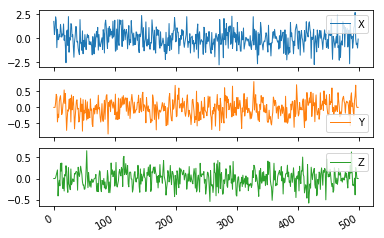

In [4]:
_ = df.plot(subplots=True, lw=1.)

## Triple-wise Granger Analysis

We use the `test_granger` function to test Granger causality on the full dataset. Boolean verdict of the Granger test are returned in the `gc` dataframe. The f-values and corresponding p-values are return in the `fstats`and `pstats` dataframe. We use an arbitrary order of 3 (maximum lag).

In [5]:
gc, fstats, pstats = test_granger(df, 3, alpha=0.01)
gc

driver,X,Y,Z
response,,,
X,NaN,False,False
Y,True,NaN,False
Z,False,True,NaN


The columns corresponds to the drivers and the rows to the response variables. We notice that Y is driven by X only an Z is driven by Y only, which corresponds to our primary model. We can have a further look on the f and p-values:

In [6]:
fstats

driver,X,Y,Z
response,,,
X,NaN,1.02869,0.275693
Y,163.775,NaN,0.167555
Z,0.994903,5.36713,NaN


In [7]:
pstats

driver,X,Y,Z
response,,,
X,NaN,0.378874,0.842968
Y,1.11022e-16,NaN,0.918287
Z,0.394303,0.00112398,NaN


We see that indeed $X_t \rightarrow 

## Pairwise Granger

### X vs Z

In [8]:
gc, fstats, pstats = test_granger(df[['X', 'Z']], 3, alpha=0.01)
gc

driver,X,Z
response,,
X,NaN,False
Z,True,NaN


We notice that if we remove Y from the model, X now Granger-cause Z.

In [9]:
print(fstats)
print(pstats)

driver          X         Z
response                   
X             NaN  0.422034
Z         7.98805       NaN
driver              X         Z
response                       
X                 NaN  0.737239
Z         2.90225e-05       NaN


### Y vs Z

In [10]:
gc, fstats, pstats = test_granger(df[['Y', 'Z']], 3, alpha=0.01)
gc

driver,Y,Z
response,,
Y,NaN,False
Z,True,NaN


In [11]:
print(fstats)
print(pstats)

driver          Y         Z
response                   
Y             NaN  0.281323
Z         12.5742       NaN
driver              Y         Z
response                       
Y                 NaN  0.838908
Z         4.52656e-08       NaN


# Comparison with statsmodels

Similar results can be obtained with the `statsmodels` implementation of VAR models.

In [12]:
import statsmodels
from statsmodels.tsa.api import VAR
statsmodels.__version__

'0.9.0'

### Triple-wise Granger analysis

In [13]:
model = VAR(df)
result = model.fit(3)
gctest = result.test_causality('Z', 'X', signif=0.01)
gctest.summary()

Test statistic,Critical value,p-value,df
0.9949,3.795,0.394,"(3, 1461)"


We see that we obtained the exact same f-statistic and p-value while testing for Granger causality on a tri-variate VAR model. 

### Pairwise Granger analysis

In [14]:
model = VAR(df[['X','Z']])
result = model.fit(3)
gctest = result.test_causality('Z', 'X', signif=0.01)
gctest.summary()

Test statistic,Critical value,p-value,df
7.988,3.802,0.000,"(3, 980)"


In [15]:
model = VAR(df[['Y','Z']])
result = model.fit(3)
gctest = result.test_causality('Z', 'Y', signif=0.01)
gctest.summary()

Test statistic,Critical value,p-value,df
12.57,3.802,0.000,"(3, 980)"


Again, similar results are obtained